# Medical Costs : How your profile affects your charges?

### Overview

This data analysis aims to explore the factors affecting the medical costs and eventually create a machine learning model to be used by the insurance companies.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Loading the Data

First, check set the working directory to the desired path.

In [2]:
os.chdir("C:\\Users\Grejell\AnacondaProjects\MedicalInsuranceAnalysis")
data = pd.read_csv(".\dta\insurance.csv")

## Exploratory Data Analysis

In [3]:
head = data.head(5)
print(head)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [4]:
describe = data.describe()
print(describe)

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


The average insurance premium is at $13,270.

In [5]:
sex = data.groupby(by = 'sex').size()
print(sex)

sex
female    662
male      676
dtype: int64


In [6]:
smoker = data.groupby(by = 'smoker').size()
print(smoker)

smoker
no     1064
yes     274
dtype: int64


In [7]:
region = data.groupby(by = 'region').size()
print(region)

region
northeast    324
northwest    325
southeast    364
southwest    325
dtype: int64


### Examining the relationship of Charges to the Categorical Features

Let us first examine the distribution of charges.

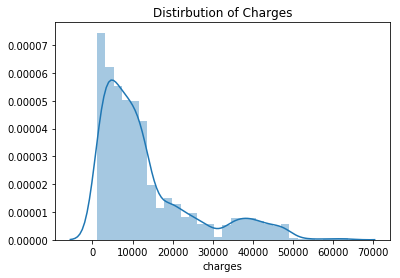

In [8]:
## check the distribution of charges
distPlot = sns.distplot(data['charges'])
plt.title("Distirbution of Charges")
plt.show(distPlot)

The graph shows it is skewed to the right. We can tell visually that there may be outliers (the maximum charge is at $63,770). Let us examine again this time between the groups.

#### Charges between Gender

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64
1387.17233389


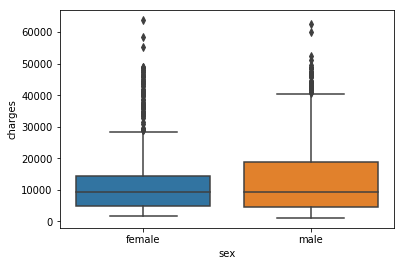

In [9]:
## check charges vs features
meanGender = data.groupby(by = "sex")["charges"].mean()
print(meanGender)
print(meanGender["male"] - meanGender["female"])
boxPlot1 = sns.boxplot(x = "sex", y = "charges", data = data)

For males, the charges are relatively higher compared to female counterparts with the difference of around $1387. 

#### Charges between Smokers and non-Smokers

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64
23615.9635337


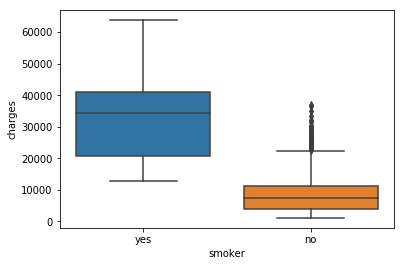

In [10]:
meanSmoker = data.groupby(by = "smoker")["charges"].mean()
print(meanSmoker)
print(meanSmoker["yes"] - meanSmoker["no"])
boxPlot2 = sns.boxplot(x = "smoker", y = "charges", data = data)

Ok, so there's around $23,615 difference between smokers and non-smokers. That's expected, what is unexpected is the huge difference between them. Smoking is very expensive indeed. ^_^

#### Charges among Regions

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64


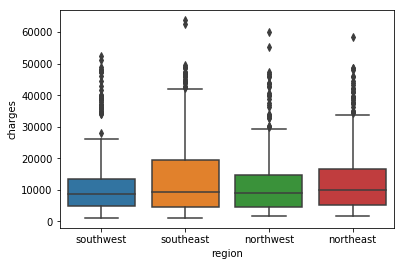

In [11]:
meanRegion = data.groupby(by = "region")["charges"].mean()
print(meanRegion)
boxPlot3 = sns.boxplot(x = "region", y = "charges", data = data)

The individuals from the Southeast has charged more on there bills. The highest charged individual also lives in the region as shown in the chart.

#### In Relation to Other Features

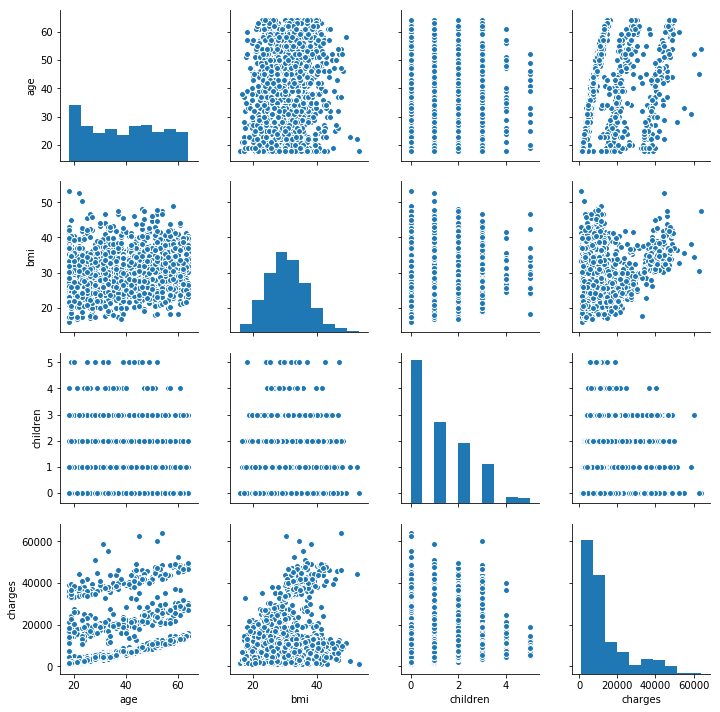

In [12]:
pairPlot = sns.pairplot(data)

Let us focus on the following relationships (first 3 charts in the bottom row):
1. charges vs age - it is apparent the that charges are higher to older individuals.
2. charges vs bmi - BMIs greater than 30 is considered obesed. The chart shows a group of individuals with BMI > 30 are charged higher.
3. charges vs no. children - those who has more children tends to have been charge lower than those who don't have.

### Pre-Processing the Data

The data involves categorical variables which need to be dummified/binarized. The continuous variables are also scaled to have a more robust model in the later part.

In [13]:
## Dummify sex, smoker and region
scaleMinMax = MinMaxScaler()
data[["age", "bmi", "children", "charges"]] = scaleMinMax.fit_transform(data[["age", "bmi", "children", "charges"]])
data = pd.get_dummies(data, prefix = ["sex", "smoker", "region"])
## retain sex = male, smoker = yes, and remove 1 region = northeast to avoid dummytrap
data = data.drop(data.columns[[4,6,11]], axis = 1)
head = data.head()
print(head)

        age       bmi  children   charges  sex_male  smoker_yes  \
0  0.021739  0.321227       0.0  0.251611         0           1   
1  0.000000  0.479150       0.2  0.009636         1           0   
2  0.217391  0.458434       0.6  0.053115         1           0   
3  0.326087  0.181464       0.0  0.333010         1           0   
4  0.304348  0.347592       0.0  0.043816         1           0   

   region_northeast  region_northwest  region_southeast  
0                 0                 0                 0  
1                 0                 0                 1  
2                 0                 0                 1  
3                 0                 1                 0  
4                 0                 1                 0  


### Linear Modeling: Quantifying the effects of the variables

We have already visualized the relationship of the variables to the charges. Now we will further investigate by looking at the relationships using multiple linear regression. Remember that the aim of this section is to quantify the relationship and not to create the prediction model. Let us first create a training and testing data set to proceed.

In [14]:
dataX = data.drop(data.columns[[3]], axis = 1)
dataY = data.iloc[:, 3]
X_train, x_test, Y_train, y_test = train_test_split(dataX, dataY, random_state = 0)

In [15]:
import statsmodels.api as sm
from scipy import stats

X_train2 = sm.add_constant(X_train)
linearModel = sm.OLS(Y_train, X_train2)
linear = linearModel.fit()
print(linear.summary())

C:\Users\Grejell\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     343.0
Date:                Sat, 07 Apr 2018   Prob (F-statistic):          1.08e-279
Time:                        12:31:28   Log-Likelihood:                 902.49
No. Observations:                1003   AIC:                            -1787.
Df Residuals:                     994   BIC:                            -1743.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0592      0.011  

Surprisingly, the regions and sex are shown to be statistically insignificant. That means there is no difference in charges between the regions and sex.

### Basic Machine Learning: Comparison between Selected Regression Models

In this section, we will create regression models and try to compare there robustness given the data. The models considered are Linear Regression, Ridge, LASSO, and ElasticNet.

This is basically what the following code does line-by-line:
    1. import the library for the model
    2. call the model
    3. fit the model
    4. predict the model using the test data
    5. get the mean squared error
    6. calculate the root mean square error
    7. get the R-squared value

#### Split the data into Train/Test data set

In [16]:
## try Linear Regression ##
from sklearn.linear_model import LinearRegression
linearModel = LinearRegression()
linear = linearModel.fit(X_train, Y_train)
linearPred = linear.predict(x_test)
mseLinear = metrics.mean_squared_error(y_test, linearPred)
rmseLinear = mseLinear**(1/2)
r2_linear = r2_score(y_test, linearPred)

In [17]:
from sklearn.linear_model import Ridge
ridgeModel = Ridge()
ridge = ridgeModel.fit(X_train, Y_train)
ridgePred = ridge.predict(x_test)
mseRidge = metrics.mean_squared_error(y_test, ridgePred)
rmseRidge = mseRidge**(1/2)
r2_ridge = r2_score(y_test, ridgePred)

In [18]:
from sklearn.linear_model import Lasso
lassoModel = Lasso()
lasso = lassoModel.fit(X_train, Y_train)
lassoPred = lasso.predict(x_test)
mseLasso = metrics.mean_squared_error(y_test, lassoPred)
rmseLasso = mseLasso**(1/2)
r2_lasso = r2_score(y_test, lassoPred)

In [19]:
from sklearn.linear_model import ElasticNet
elasticNetModel = ElasticNet(alpha = 0.01, l1_ratio = 0.9, max_iter = 20)
ElasticNet = elasticNetModel.fit(X_train, Y_train)
ElasticNetPred = ElasticNet.predict(x_test)
mseElasticNet = metrics.mean_squared_error(y_test, ElasticNetPred)
rmseElasticNet = mseElasticNet**(1/2)
r2_elastic = r2_score(y_test, ElasticNetPred)

#### Comparing the Models

In [20]:
performanceData = pd.DataFrame({"model":["linear", "lasso", "ridge", "elasticnet"], "rmse":[rmseLinear, rmseLasso, rmseRidge, rmseElasticNet], "r-squared":[r2_linear, r2_lasso, r2_ridge, r2_elastic]})
print(performanceData)

        model  r-squared      rmse
0      linear   0.795879  0.090486
1       lasso  -0.000302  0.200311
2       ridge   0.795261  0.090623
3  elasticnet   0.711564  0.107563


Based on the table above, linear regression has a slight edge among the models considered. It has the least RMSE and the highest R-Square. This is not surprising as the other 3 models are known to be more robust when there are quite a number of features. We only have 8 this time.

#### Conclusion

We have found out that region and sex does not bring significant difference on charges among its groups. Age, BMI, number of children and smoking are the once that drives the charges.
Meanwhile, linear regression has edged the regularized regression models in giving the best prediction. This proves that regularized regression models are not guaranteed to be superior to linear regressions.